# compare BNB and EXTBNB data to MC-BNB/DATA cosmic overlay 

In [1]:
import sys; sys.path.insert(0, '../../'); sys.path.insert(0,'../mupClassification/')
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from matplotlib.pylab import *
import matplotlib.patches as patches
import pprint; pp = pprint.PrettyPrinter(indent=4)
%matplotlib inline

OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before sof. trig.
MC_scaling_DATAcosmic: 0.507547428293 = N(POT on beam)/N(POT MC)


In [2]:
pd.set_option('precision', 2)

In [3]:
debug = 1
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/OnOffComparisonsPlayground/'

In [4]:
OffBeam = pd.concat([pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/ccqe_candidates/prod_reco_optfilter_extbnb_v12_mcc8_dev_04_2018_04_11_vertices.csv')
                     ,pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/ccqe_candidates/prod_reco_optfilter_extbnb_v12_mcc8_dev_05_2018_04_05_vertices.csv')])
OffBeamFV = sample_in_FV(OffBeam)
print len(OffBeam),'pairs from Off-Beam'
print len(OffBeamFV),'pairs from Off-Beam in FV'
print 'OffBeam_scaling',OffBeam_scaling

OnBeam = pd.concat([pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/ccqe_candidates/prod_reco_optfilter_bnb_v12_unblind_mcc8_04_2018_04_19_vertices.csv')
                     ,pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/ccqe_candidates/prod_reco_optfilter_bnb_v12_unblind_mcc8_05_2018_04_18_vertices.csv')])
OnBeamFV = sample_in_FV(OnBeam)
print len(OnBeam),'pairs from On-Beam'
print len(OnBeamFV),'pairs from On-Beam in FV'
print 'MC_scaling_DATAcosmic',MC_scaling_DATAcosmic


MCbnbDATAcosmicPairsFV, MCbnbDATAcosmicSamples = load_MCbnbDATAcosmicSamples(filename='prodgenie_bnb_nu_uboone_overlay_mcc8_v4_2018_04_18_vertices')
print "len(MCbnbDATAcosmicPairsFV['cosmic']):",len(MCbnbDATAcosmicPairsFV['cosmic'])

34730 pairs from Off-Beam
21107 pairs from Off-Beam in FV
OffBeam_scaling 0.706302660161
38199 pairs from On-Beam
24345 pairs from On-Beam in FV
MC_scaling_DATAcosmic 0.507547428293


KeyError: 'starty_muCandidate'

In [ ]:
# ------------------------------------------------
# April-4
def gen_Noverlay(reducedSamples=None,cut_name=''
                 ,f_POT = MC_scaling_DATAcosmic
                 ,N_On=len(OnBeamFV) # number of pairs in BeamOn before event-selection cuts
                 ,debug=0
                ):
    # @return the number of events in each subsample of the overlay, POT-normalized
    N = dict()
    N['Cosmic'],N['mup'],N['others'] = float(len(reducedSamples[cut_name]['cosmic'])),float(len(reducedSamples[cut_name]['1mu-1p'])),float(len(reducedSamples[cut_name]['other pairs']))
    N['MC'] = N['mup'] + N['others']
    N['Overlay'] = N['Cosmic'] + N['MC']                     
    N['eff Overlay'] = N['Overlay']/(len(reducedSamples['no cut']['cosmic'])
                                     +len(reducedSamples['no cut']['1mu-1p'])                                     
                                     +len(reducedSamples['no cut']['other pairs']))
    N['Overlay POT Scaled'] = f_POT*(N['Cosmic'] + N['MC'])
    # scale the cosmic in the MC
    N['Cosmic original'] = float(len(reducedSamples['no cut']['cosmic']))
    f_Cosmic = (1./N['Cosmic original'])*(N_On/f_POT - N['MC'])
    N['Cosmic Scaled'] = f_Cosmic*N['Cosmic']
    N['Overlay Cosmic Scaled'] = N['MC'] + N['Cosmic Scaled']
    N['eff Overlay Cosmic Scaled'] = (N['Overlay Cosmic Scaled']
                                      /(f_Cosmic*len(reducedSamples['no cut']['cosmic'])                                                    
                                        +len(reducedSamples['no cut']['1mu-1p'])
                                        +len(reducedSamples['no cut']['other pairs'])))
    N['Overlay Cosmic & POT Scaled'] = f_POT*N['Overlay Cosmic Scaled']
    if debug:         
        print "N['Cosmic original']:",N['Cosmic original']
        print 'N_On:',N_On,',f_Cosmic:',f_Cosmic
        print 'Noverlay in',cut_name
        print N
    return N,f_Cosmic
# ------------------------------------------------

In [8]:
# ------------------------------------------------
# March-6, 2018 (last edit April-7)
def apply_cuts_to_overlay(MCbnbDATAcosmicSamples=None
                          ,N_On=1 # number of pairs in BeamOn before event-selection cuts
                          ,PIDa_p_min=13
                          ,minPEcut = 100
                          ,maxdYZcut = 200
                          ,delta_theta_12=55  # deg.
                          ,opt_box=(50,100) # [Nwires x Nticks]
                          ,r_max_RdQ_CC1p0pi = 0.35 # sphere in U,V,Y space, apply a cut only to CC1p0pi
                          ,delta_Delta_phi=35 # deg.
                          ,Pt_max=0.35        # GeV/c
                          ,cuts_order=['no cut']
                          ,debug=0,f_POT = MC_scaling_DATAcosmic
                          ,do_PIDaCali=True
                          ):    

    cut_name = 'no cut'
    reducedSamples = dict()
    pureffOverlay = pd.DataFrame()
    reducedSamples['no cut'] = dict()
    numbers = pd.DataFrame()
    for pair_type in pair_types: reducedSamples['no cut'][pair_type] = MCbnbDATAcosmicSamples[pair_type]
    pureffOverlay = get_pureff_cut(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples ,pureff=pureffOverlay,cut_name=cut_name,reduced=reducedSamples[cut_name])
    Noverlay,_ = gen_Noverlay(reducedSamples=reducedSamples,cut_name=cut_name,N_On=N_On,debug=debug,f_POT=f_POT )
    numbers = numbers.append(pd.DataFrame({ r'$N_{Overlay}$':Noverlay['Overlay']
                                           ,r'${\epsilon}_{Overlay}$ [%]':100                                        
                                           ,r'$N_{Overlay, cosmic-scaled}$':Noverlay['Overlay Cosmic Scaled']
                                           ,r'$N_{Overlay, cosmic-scaled}^{POT-scaled}$':Noverlay['Overlay Cosmic & POT Scaled']
                                           ,r'${\epsilon}_{Overlay, cosmic-scaled}$ [%]':100
                                           ,r'$N_{cosmic}$':Noverlay['Cosmic']
                                           ,r'$N_{cosmic, cosmic-scaled}$':Noverlay['Cosmic Scaled']                                                                                    
                                           ,r'$N_{cosmic, cosmic-scaled}^{POT-scaled}$':f_POT*Noverlay['Cosmic Scaled']                                          
                                          },index=['preselection']))

    
    for i_cut,cut in zip(range(1,len(cuts_order)),cuts_order[1:]):#{
        reduced = dict()
        print 'grabbing reduced samples after (',cuts_order[i_cut-1],') and applying cut on (',cuts_order[i_cut],')'
        samples_previous_cut = reducedSamples[cuts_order[i_cut-1]]
        print 'len(samples_previous_cut):',len(samples_previous_cut)

        for pair_type in pair_types:#{
            sam = samples_previous_cut[pair_type]
            print 'sam('+pair_type+'):',len(sam)

            
            if cut == 'PIDa':
                if do_PIDaCali:
                    reduced[pair_type] = sam[sam['PIDaCali_assigned_proton']>PIDa_p_min]
                else:
                    reduced[pair_type] = sam[sam['PIDa_assigned_proton']>PIDa_p_min]

            
            elif cut == 'flash':
                reduced[pair_type] = sam[(sam['Nflashes']>0)
                                         &(sam['ClosestFlash_TotalPE'] > minPEcut)
                                         &(sam['ClosestFlash_YZdistance'] < maxdYZcut)]
            
            elif cut == 'length':
                reduced[pair_type] = sam[sam['PIDa_long'] < sam['PIDa_short']]
    
            elif cut == 'non-collinearity':
                reduced[pair_type] = sam[np.abs(sam['theta_12']-90)<delta_theta_12]
            
            elif cut == 'vertex activity':
                R_str = 'RdQaroundVertex'
                box_str='[%d wires x %d ticks]'%(opt_box[0],opt_box[1])
                Ru,Rv,Ry = R_str+'[plane 0]'+box_str,R_str+'[plane 1]'+box_str,R_str+'[plane 2]'+box_str
                reduced[pair_type] = sam[(sam[Ru]==1) | (sam[Rv]==1) | (sam[Ry]==1)
                                         |
                                         (sqrt( np.square(sam[Ru]-1) + square(sam[Rv]-1) + square(sam[Ry]-1) )
                                          <= r_max_RdQ_CC1p0pi) ]
            elif cut == 'delta phi':
                reduced[pair_type] = sam[np.abs(sam['delta_phi']-180.)<delta_Delta_phi]

            elif cut == 'soft Pt':
                reduced[pair_type] = sam[sam['reco_Pt']<Pt_max]
        #}
        reducedSamples[cut] = reduced
        pureffOverlay = get_pureff_cut(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                                       ,pureff=pureffOverlay,cut_name=cut,reduced=reduced)
    #}
        Noverlay,_ = gen_Noverlay(reducedSamples=reducedSamples,cut_name=cut,N_On=N_On,debug=debug,f_POT=f_POT )
        numbers = numbers.append(pd.DataFrame({ r'$N_{Overlay}$':Noverlay['Overlay']
                                           ,r'${\epsilon}_{Overlay}$ [%]':100.*Noverlay['eff Overlay']
                                           ,r'$N_{Overlay, cosmic-scaled}$':Noverlay['Overlay Cosmic Scaled']
                                           ,r'$N_{Overlay, cosmic-scaled}^{POT-scaled}$':Noverlay['Overlay Cosmic & POT Scaled']
                                           ,r'${\epsilon}_{Overlay, cosmic-scaled}$ [%]':100.*Noverlay['eff Overlay Cosmic Scaled']
                                           ,r'$N_{cosmic}$':Noverlay['Cosmic']
                                           ,r'$N_{cosmic, cosmic-scaled}$':Noverlay['Cosmic Scaled']                                                                                    
                                           ,r'$N_{cosmic, cosmic-scaled}^{POT-scaled}$':f_POT*Noverlay['Cosmic Scaled']                                          
                                          },index=[cut]))
    return reducedSamples,pureffOverlay,numbers
# -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- -



In [ ]:
# cuts_pureff = apply_cuts_MCbnbDATAcosmic()
cuts_pureff = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,do_PIDaCali=True
                                    ,cuts_order  = ['no cut','PIDa','flash','length','vertex activity','delta phi','soft Pt'] )
reducedOverlay,pureff_MCbnbDATAcosmic,pureff_MCbnbDATAcosmic_numbers = cuts_pureff
pureff_MCbnbDATAcosmic

In [9]:

# ------------------------------------------------
# March-6, 2018 (last edit March 29)
def apply_cuts_to_data(PIDa_p_min=13,do_PIDaCali=False
                       ,minPEcut = 100
                       ,maxdYZcut = 200
                       ,delta_theta_12=55  # deg.
                       ,opt_box=(50,100) # [Nwires x Nticks]
                       ,r_max_RdQ_CC1p0pi = 0.35 # sphere in U,V,Y space, apply a cut only to CC1p0pi
                       ,delta_Delta_phi=35 # deg.
                       ,Pt_max=0.35        # GeV/c
                       ,OnBeamFV=None,OffBeamFV=None
                       ,cuts_order=['no cut','PIDa','flash','length','non-collinearity','vertex activity','delta phi','soft Pt']
                       ,debug=0
                       ):
    reducedOnBeam, reducedOffBeam = dict(), dict()
    
    reducedOnBeam['no cut'] = OnBeamFV
    reducedOffBeam['no cut'] = OffBeamFV
    numbers = pd.DataFrame()

    numbers = numbers.append(pd.DataFrame({'$N_{On}$':len(OnBeamFV)
                                           ,r'${\epsilon}_{On}$ [%]':100.                                           
                                           ,'$N_{Off}$':len(OffBeamFV)
                                           ,r'${\epsilon}_{Off}$ [%]':100.                                              
                                           ,'$N_{On-Off}$':(len(OnBeamFV)-OffBeam_scaling*len(OffBeamFV))
                                           ,r'${\epsilon}_{On-Off}$ [%]':100
                                           ,'$N_{Off}^{scaled}$':OffBeam_scaling*len(OffBeamFV)
                                         },index=['preselection']))

    for i_cut,cut in zip(range(1,len(cuts_order)),cuts_order[1:]):#{
        if debug: print 'grabbing reduced data samples after (',cuts_order[i_cut-1],') and applying cut on (',cuts_order[i_cut],')'
        OnBeam_previous_cut = reducedOnBeam[cuts_order[i_cut-1]]
        OffBeam_previous_cut = reducedOffBeam[cuts_order[i_cut-1]]
        if debug: print 'len(OnBeam_previous_cut):',len(OnBeam_previous_cut),'len(OffBeam_previous_cut):',len(OffBeam_previous_cut)

        
        for sam,sam_name in zip([OnBeam_previous_cut,OffBeam_previous_cut]
                                ,['OnBeam','OffBeam']):#{
            if debug: print 'len('+sam_name+'):',len(sam)
            if cut == 'PIDa':
                if do_PIDaCali:
                    sam = sam[sam['PIDaCali_assigned_proton']>PIDa_p_min]
                else:
                    sam = sam[sam['PIDa_assigned_proton']>PIDa_p_min]
            
            elif cut == 'flash':
                sam = sam[(sam['Nflashes']>0)
                          &(sam['ClosestFlash_TotalPE'] > minPEcut)
                          &(sam['ClosestFlash_YZdistance'] < maxdYZcut)]
            
            elif cut == 'length':
                sam = sam[sam['PIDa_long'] < sam['PIDa_short']]
    
            elif cut == 'non-collinearity':
                sam = sam[np.abs(sam['theta_12']-90)<delta_theta_12]
                    
            elif cut == 'vertex activity':
                R_str = 'RdQaroundVertex'
                box_str='[%d wires x %d ticks]'%(opt_box[0],opt_box[1])
                Ru,Rv,Ry = R_str+'[plane 0]'+box_str,R_str+'[plane 1]'+box_str,R_str+'[plane 2]'+box_str
                sam = sam[(sam[Ru]==1) | (sam[Rv]==1) | (sam[Ry]==1)
                          |
                          (sqrt( np.square(sam[Ru]-1) + square(sam[Rv]-1) + square(sam[Ry]-1) )
                           <= r_max_RdQ_CC1p0pi) ]
            elif cut == 'delta phi':
                sam = sam[np.abs(sam['delta_phi']-180.)<delta_Delta_phi]
                                      
            elif cut == 'soft Pt':
                sam = sam[sam['reco_Pt']<Pt_max]
                                              
            if sam_name=='OnBeam': reducedOnBeam[cut] = sam
            if sam_name=='OffBeam': reducedOffBeam[cut] = sam
        #}
        numbers = numbers.append(pd.DataFrame({'$N_{On}$':len(reducedOnBeam[cut])                                               
                                               ,r'${\epsilon}_{On}$ [%]':(100.*float(len(reducedOnBeam[cut]))/len(OnBeamFV))                                               
                                               ,'$N_{Off}$':len(reducedOffBeam[cut])
                                               ,r'${\epsilon}_{Off}$ [%]':(100.*float(len(reducedOffBeam[cut]))/len(OffBeamFV))
                                              ,'$N_{On-Off}$':(len(reducedOnBeam[cut])-OffBeam_scaling*len(reducedOffBeam[cut]))
                                              ,r'${\epsilon}_{On-Off}$ [%]':(100*(len(reducedOnBeam[cut])-OffBeam_scaling*len(reducedOffBeam[cut]))                                                           
                                                                      /(len(OnBeamFV)-OffBeam_scaling*len(OffBeamFV)))
                                               ,'$N_{Off}^{scaled}$':OffBeam_scaling*len(reducedOffBeam[cut])
                                              }
                                             ,index=[cut]))
    #}
    return reducedOnBeam,reducedOffBeam,numbers
# -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- -


# Reweight the cosmic in the overlay to match the OffBeam before any post-selection cuts, and then check what happens to the On-Off beam after all cuts

# overlay subsamples-scaling

In [10]:
def get_samples_scaling( N_total=1 # total integral of all overlay 
                        , f_Cosmic=None  # fraction of cosmic in the overlay, need to be in the range 0-1
                        , OverlaySubsamples=None
                        , debug=0
                        , f_POT=MC_scaling_DATAcosmic):
    # return the total scaling factor of each of the overlay subsamples
    scaling,N,f = dict(),dict(),dict()
    
    for pair_type in pair_types: N[pair_type] = float(len(OverlaySubsamples[pair_type]))
    N['MC'] = N['1mu-1p']+N['other pairs']
    if N_total=='MC(tot) x POT':
        N['total']=(N['MC']+N['cosmic'])*f_POT
    else:
        N['total']=N_total
    
    if f_Cosmic is None:
        f['Cosmic'] = N['cosmic']/(N['MC']+N['cosmic'])
    else:
        f['Cosmic'] = f_Cosmic
    f['MC'] = 1-f['Cosmic']
        
    f['1mu-1p in MC'] = N['1mu-1p']/N['MC']
    f['CC 1p 0pi in MC'] = N['CC 1p 0pi']/N['MC']
    f['other pairs in MC'] = N['other pairs']/N['MC']
                
    # f_Cosmic = fraction of cosmic in the overlay
    scaling['cosmic']     = N['total']*f['Cosmic']/N['cosmic']
    scaling['other pairs']= N['total']*f['MC']*f['other pairs in MC']/N['other pairs']
    scaling['1mu-1p']     = N['total']*f['MC']*f['1mu-1p in MC']/N['1mu-1p']
    scaling['CC 1p 0pi']  = N['total']*f['MC']*f['CC 1p 0pi in MC']/N['CC 1p 0pi']
    
    if debug: 
        print 'N';pp.pprint(N)
        print 'f';pp.pprint(f)
        print 'scaling:';pp.pprint(scaling)
    return scaling

In [11]:
f_Cosmic=0.92
overlay_scalings = dict()
overlay_scalings['only POT'] = get_samples_scaling( N_total='MC(tot) x POT' # total integral of all overlay 
                                      , f_Cosmic=None  # fraction of cosmic in the overlay, need to be in the range 0-1
                                      , OverlaySubsamples=reducedOverlay['no cut'], debug=2, f_POT=MC_scaling_DATAcosmic)
overlay_scalings['POT scaling and f(cosmic)=%.2f'%f_Cosmic] = get_samples_scaling( N_total='MC(tot) x POT'  # total integral of all overlay                                       
                                                                         , f_Cosmic=f_Cosmic  # fraction of cosmic in the overlay, need to be in the range 0-1
                                                                         , OverlaySubsamples=reducedOverlay['no cut'], debug=2, f_POT=MC_scaling_DATAcosmic)
overlay_scalings['N(On) scaling'] = get_samples_scaling( N_total= float(len(OnBeamFV)) # total integral of all overlay                                       
                                               , f_Cosmic=None  # fraction of cosmic in the overlay, need to be in the range 0-1
                                               , OverlaySubsamples=reducedOverlay['no cut'], debug=2, f_POT=MC_scaling_DATAcosmic)
overlay_scalings['N(On) scaling and f(cosmic)=%.2f'%f_Cosmic] = get_samples_scaling( N_total= float(len(OnBeamFV)) # total integral of all overlay                                       
                                                                         , f_Cosmic=f_Cosmic  # fraction of cosmic in the overlay, need to be in the range 0-1
                                                                         , OverlaySubsamples=reducedOverlay['no cut'], debug=2, f_POT=MC_scaling_DATAcosmic)
print 'overlay scalings';pp.pprint(overlay_scalings)

NameError: name 'reducedOverlay' is not defined

In [12]:
# -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- -
# Nov-20,2017 (last editted Marc-20, 2018)
def plot_stacked_MCsamples( ax=None, debug=0,overlay_scaling=None
                           , reducedOverlay=None, cut_name='no cut'
                           , MCbnbDATAcosmicSamples=None
                           , var=None, x_label='',y_label='', bins=None , alpha=0.8, fontsize=25
                           , remove_ticks_x=False
                           , remove_ticks_y=False , xlim=None
                           , do_add_legend=False
                           , do_individual_histograms=True,stackColor='black',stackLabel='MC'):
    '''
    return: h, bins
            stacked histogram values and bins,
            of the samples from the overlay: 
            (cosmic, other-pairs) + 1mu 1p pairs
    '''
    bin_width = bins[1]-bins[0]    
    mid = 0.5*(bins[:-1]+bins[1:])
    h,labels,colors,N = dict(),dict(),dict(),dict()    

    for i_pair_type,pair_type in enumerate(pair_types):
        sample = reducedOverlay[cut_name][pair_type]
        N[pair_type] = float(len(sample))
        Noriginal = len(MCbnbDATAcosmicSamples[pair_type])
        labels[pair_type] = MClabels[i_pair_type]+' (%.1f=%.1f'%(N[pair_type],100.*N[pair_type]/Noriginal)+'%)'
        colors[pair_type] = MCcolors[i_pair_type];
        x = sample[var]
        x = x[x<1e5]
        h[pair_type],edges = np.histogram(x,bins=bins)
        h[pair_type+' scaled'] = overlay_scaling[pair_type]*h[pair_type]
    # -- - - - --------- - - -- ---- -  - --- -- -- -- --
    
    if debug>1: 
        print "stacked_MCsamples (bins[:-1]):\n",bins[:-1]
        print "np.sum(h['cosmic']):",np.sum(h['cosmic'])
        print "np.sum(h['cosmic scaled']):",np.sum(h['cosmic scaled'])
        print "np.sum(h['1mu-1p']):",np.sum(h['1mu-1p'])
        print "np.sum(h['1mu-1p scaled']):",np.sum(h['1mu-1p scaled'])
        print "np.sum(h['other pairs']):",np.sum(h['other pairs'])

    if do_individual_histograms:
        # mu-p  
        plt.bar(mid,h['cosmic scaled']+h['other pairs scaled']+h['1mu-1p scaled'] , width=bin_width
                         ,color=colors['1mu-1p'],alpha=alpha, label=labels['1mu-1p'])
        # CC 1p 0pi
        plt.bar(mid,h['cosmic scaled']+h['other pairs scaled']+h['CC 1p 0pi scaled'] , width=bin_width
                         ,color=colors['CC 1p 0pi'],alpha=alpha, label=labels['CC 1p 0pi'])
        # other pairs
        plt.bar(mid,h['cosmic scaled']+h['other pairs scaled'] , width=bin_width
                         ,color=colors['other pairs'],alpha=alpha , label=labels['other pairs'])
        # cosmic
        plt.bar(mid, h['cosmic scaled'] , width=bin_width
                         ,color=colors['cosmic'],alpha=alpha, label=labels['cosmic'])
    
    # all
    h_stack = h['cosmic scaled']+h['other pairs scaled']+h['1mu-1p scaled']
    plt.step(mid+0.5*bin_width,h_stack ,color=stackColor,alpha=alpha, label=stackLabel)
        

    if np.max(h_stack)>np.max(ax.get_ylim()): ax.set_ylim(np.min(ax.get_ylim()),1.05*np.max(h_stack))
    set_axes(ax,x_label=x_label,y_label=y_label,do_add_grid=True,fontsize=fontsize,do_add_legend=do_add_legend
             ,xlim=(np.min(bins)-0.5*bin_width,np.max(bins)+0.5*bin_width) if xlim is None else xlim
             ,remove_ticks_x=remove_ticks_x             
             ,remove_ticks_y=remove_ticks_y                 
            )    
    return h_stack , bins
# -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- -

In [13]:
def plot_nocut_finalcut(var='theta_12',x_label= r'$\theta_{1,2}$ [deg.]',bins=linspace(0,180,31)
                        ,scaling_name='N(On) scaling and f(cosmic)=0.92'
                        ,scaling_color ='black',x_ticks=None
                        ,figsize=(24,8)
                        ,overlay_scalings=None,do_OffBeam=False
                        ,reducedOffBeam=None,reducedOnBeam=None,reducedOverlay=None
                        ,f_Cosmic=None
                        ,chi2_xrange=None,xlim=None
                        ,last_cut_name='soft Pt',last_cut_label='detection + kinematical cuts'
                        ,debug=0
                        ,do_varcut=True,x_varcut=(13,np.inf),do_only_preselection=False
                       ):
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(1,1 if do_only_preselection else 2 ,1)
    cut_name,cut_label='no cut','preselection'
    if do_OffBeam:
        _,h_OffBeam = plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut']
                               ,color='white', var=var, bins=bins, ax=ax , do_OffBeam_scaling=True)
    _,h_OnBeam = plot_OnBeam(OnBeamSample=reducedOnBeam[cut_name],OnBeamFV=reducedOnBeam['no cut']
                             ,color='black', var=var, bins=bins, ax=ax)
    h_stack,_=plot_stacked_MCsamples( debug=0,overlay_scaling=overlay_scalings[scaling_name]
                                     , cut_name=cut_name
                                     , reducedOverlay=reducedOverlay
                                     , MCbnbDATAcosmicSamples = MCbnbDATAcosmicSamples
                                     , var=var, x_label=x_label, y_label='overlay prediction',xlim=xlim
                                     , bins=bins , alpha=0.8, ax=ax
                                     , do_add_legend=False
                                    );
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=(np.min(bins),np.max(bins))
                                     , h1=h_OnBeam , h2=h_stack 
                                     , h1err=np.sqrt(h_OnBeam), h2err=np.sqrt(h_stack)
                                     , debug=0 )
    chi2_txt = r'$\chi^2/ndf=%.1f/%d$'%(chi2,ndf)
    ax.set_title(cut_label+(', $f_{cosmic}=%.2f$'%f_Cosmic if f_Cosmic is not None else '') + ',' + chi2_txt
                 ,y=1.02,fontsize=25)
    if do_varcut:
        plt.plot([x_varcut[0],x_varcut[0]],ax.get_ylim(),'--',[x_varcut[1],x_varcut[1]],ax.get_ylim(),'--',color='black')
    if debug:
        print 'preselection:'
        print 'np.sum(h_OnBeam):',np.sum(h_OnBeam)
        print 'np.sum(h_stack):',np.sum(h_stack)

    if do_only_preselection: return 

    ax = fig.add_subplot(1,2,2)
    cut_name,cut_label=last_cut_name,last_cut_label
    ax.set_title(cut_label,y=1.02,fontsize=25)
    if do_OffBeam:
        _,h_OffBeam = plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut']
                                   ,color='white', var=var, bins=bins, ax=ax , do_OffBeam_scaling=True)
    _,h_OnBeam = plot_OnBeam(OnBeamSample=reducedOnBeam[cut_name],OnBeamFV=reducedOnBeam['no cut']
                             ,color='black', var=var, bins=bins, ax=ax)
    h_stack,_= plot_stacked_MCsamples( debug=0, overlay_scaling=overlay_scalings[scaling_name]
                                          , stackColor=scaling_color, stackLabel=scaling_name
                                          , cut_name=cut_name
                                          , reducedOverlay=reducedOverlay
                                          , MCbnbDATAcosmicSamples = MCbnbDATAcosmicSamples
                                          , var=var, x_label=x_label, y_label='overlay prediction',xlim=xlim
                                          , bins=bins , alpha=0.8, ax=ax
                                          , do_individual_histograms=True if scaling_name=='N(On) scaling and f(cosmic)=0.92' else False
                                          , do_add_legend=False);
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange
                                     , h1=h_OnBeam , h2=h_stack 
                                     , h1err=np.sqrt(h_OnBeam), h2err=np.sqrt(h_stack)
                                     , debug=0 )
    chi2_txt = r'$\chi^2/ndf=%.1f/%d$'%(chi2,ndf)
    ax.set_title(cut_label+(', $f_{cosmic}=%.2f$'%f_Cosmic if f_Cosmic is not None else '') + ',' + chi2_txt
                 ,y=1.02,fontsize=25)
    if do_varcut:
        plt.plot([x_varcut[0],x_varcut[0]],ax.get_ylim(),'--',[x_varcut[1],x_varcut[1]],ax.get_ylim(),'--',color='black')

    # ax=OnBeam_minus_OffBeam_1d(debug=0,doOffBeam_scaling=True                                   
    #                            ,OnBeamSample=reducedOnBeam[cut_name] ,OriginalOnBeamSample=reducedOnBeam['no cut']                           
    #                            ,OffBeamSample=reducedOffBeam[cut_name]  ,OriginalOffBeamSample=reducedOffBeam['no cut']                        
    #                            ,var=var , x_label='' ,bins=bins  , ax=ax, do_add_legend=False                           
    #                           )  
    plt.tight_layout()

# should we use calibrated PIDa or not?

In [ ]:
do_PIDaCali = False

## $l_\mu - l_p$

In [15]:
OnBeamFV['l_mu-l_p'] = OnBeamFV['l_assigned_muon'] - OnBeamFV['l_assigned_proton']
OffBeamFV['l_mu-l_p'] = OffBeamFV['l_assigned_muon'] - OffBeamFV['l_assigned_proton']

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [16]:
for pair_type in pair_types:
    MCbnbDATAcosmicSamples[pair_type]['l_mu-l_p'] = (MCbnbDATAcosmicSamples[pair_type]['l_assigned_muon'] 
                                                     - MCbnbDATAcosmicSamples[pair_type]['l_assigned_proton'])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [17]:
cuts_order  = ['no cut','PIDa','flash','non-collinearity','vertex activity','delta phi','soft Pt'] 
cuts_labels = ['preselection','PIDa cut','PMT cuts','collinearity cut','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut'] 

reducedOverlay,pureffOverlay,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to data'

grabbing reduced samples after ( no cut ) and applying cut on ( PIDa )
len(samples_previous_cut): 4
sam(1mu-1p): 5060
sam(other pairs): 4071
sam(cosmic): 9005
sam(CC 1p 0pi): 2389
grabbing reduced samples after ( PIDa ) and applying cut on ( flash )
len(samples_previous_cut): 4
sam(1mu-1p): 4284
sam(other pairs): 2268
sam(cosmic): 1300
sam(CC 1p 0pi): 2006
grabbing reduced samples after ( flash ) and applying cut on ( non-collinearity )
len(samples_previous_cut): 4
sam(1mu-1p): 4033
sam(other pairs): 2190
sam(cosmic): 638
sam(CC 1p 0pi): 1876
grabbing reduced samples after ( non-collinearity ) and applying cut on ( vertex activity )
len(samples_previous_cut): 4
sam(1mu-1p): 3571
sam(other pairs): 1491
sam(cosmic): 331
sam(CC 1p 0pi): 1724
grabbing reduced samples after ( vertex activity ) and applying cut on ( delta phi )
len(samples_previous_cut): 4
sam(1mu-1p): 2393
sam(other pairs): 845
sam(cosmic): 158
sam(CC 1p 0pi): 1494
grabbing reduced samples after ( delta phi ) and applying c

preselection:
np.sum(h_OnBeam): 24283
np.sum(h_stack): 24286.0042423


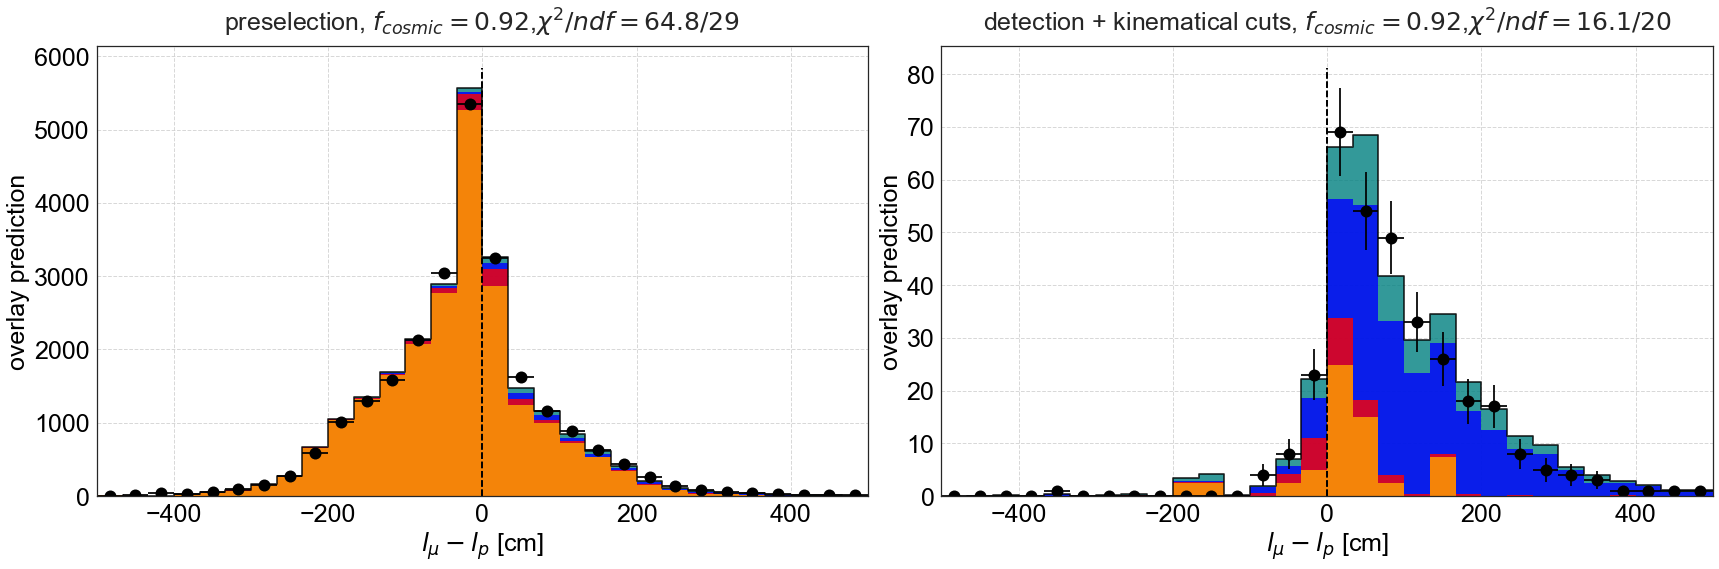

In [76]:
plot_nocut_finalcut(var='l_mu-l_p',x_label= r'$l_{\mu}-l_p$ [cm]',bins=linspace(-500,500,31)
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'        
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic,xlim=(-500,500),chi2_xrange=(-200,500),debug=2,x_varcut=(0,0)
                   )

## collinearity

In [77]:
cuts_order  = ['no cut','PIDa','flash','length','vertex activity','delta phi','soft Pt'] 
cuts_labels = ['preselection','PIDa cut','PMT cuts',r'$l_\mu > l_p$ cut','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut'] 

reducedOverlay,pureffOverlay,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to data'

grabbing reduced samples after ( no cut ) and applying cut on ( PIDa )
len(samples_previous_cut): 4
sam(1mu-1p): 5060
sam(other pairs): 4071
sam(cosmic): 9005
sam(CC 1p 0pi): 2389
grabbing reduced samples after ( PIDa ) and applying cut on ( flash )
len(samples_previous_cut): 4
sam(1mu-1p): 4284
sam(other pairs): 2268
sam(cosmic): 1300
sam(CC 1p 0pi): 2006
grabbing reduced samples after ( flash ) and applying cut on ( length )
len(samples_previous_cut): 4
sam(1mu-1p): 4033
sam(other pairs): 2190
sam(cosmic): 638
sam(CC 1p 0pi): 1876
grabbing reduced samples after ( length ) and applying cut on ( vertex activity )
len(samples_previous_cut): 4
sam(1mu-1p): 3336
sam(other pairs): 1205
sam(cosmic): 342
sam(CC 1p 0pi): 1656
grabbing reduced samples after ( vertex activity ) and applying cut on ( delta phi )
len(samples_previous_cut): 4
sam(1mu-1p): 2227
sam(other pairs): 730
sam(cosmic): 156
sam(CC 1p 0pi): 1425
grabbing reduced samples after ( delta phi ) and applying cut on ( soft Pt )
le

preselection:
np.sum(h_OnBeam): 24345
np.sum(h_stack): 24345.0


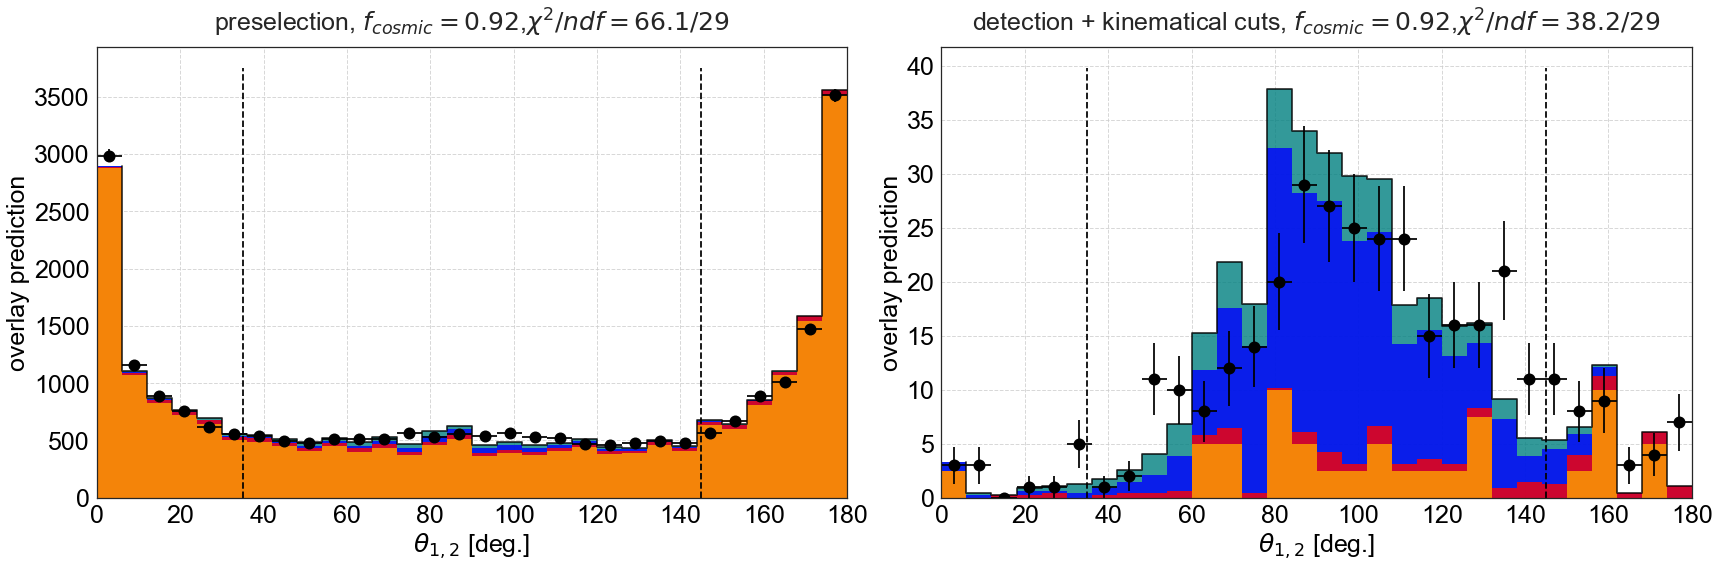

In [78]:
plot_nocut_finalcut(var='theta_12',x_label= r'$\theta_{1,2}$ [deg.]',bins=linspace(0,180,31)
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic,xlim=(0,180),chi2_xrange=(0,180),debug=2,x_varcut=(35,145)
                   )

## $\Delta \phi$

In [79]:
cuts_order  = ['no cut','PIDa','flash','length','non-collinearity','vertex activity','soft Pt']
cuts_labels = ['preselection','PIDa cut','PMT cuts',r'$l_\mu > l_p$ cut','collinearity','vertex activity',r'$p_t$ cut']
reducedOverlay,pureffOverlay,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to data'

grabbing reduced samples after ( no cut ) and applying cut on ( PIDa )
len(samples_previous_cut): 4
sam(1mu-1p): 5060
sam(other pairs): 4071
sam(cosmic): 9005
sam(CC 1p 0pi): 2389
grabbing reduced samples after ( PIDa ) and applying cut on ( flash )
len(samples_previous_cut): 4
sam(1mu-1p): 4284
sam(other pairs): 2268
sam(cosmic): 1300
sam(CC 1p 0pi): 2006
grabbing reduced samples after ( flash ) and applying cut on ( length )
len(samples_previous_cut): 4
sam(1mu-1p): 4033
sam(other pairs): 2190
sam(cosmic): 638
sam(CC 1p 0pi): 1876
grabbing reduced samples after ( length ) and applying cut on ( non-collinearity )
len(samples_previous_cut): 4
sam(1mu-1p): 3336
sam(other pairs): 1205
sam(cosmic): 342
sam(CC 1p 0pi): 1656
grabbing reduced samples after ( non-collinearity ) and applying cut on ( vertex activity )
len(samples_previous_cut): 4
sam(1mu-1p): 2969
sam(other pairs): 819
sam(cosmic): 189
sam(CC 1p 0pi): 1533
grabbing reduced samples after ( vertex activity ) and applying cut on 

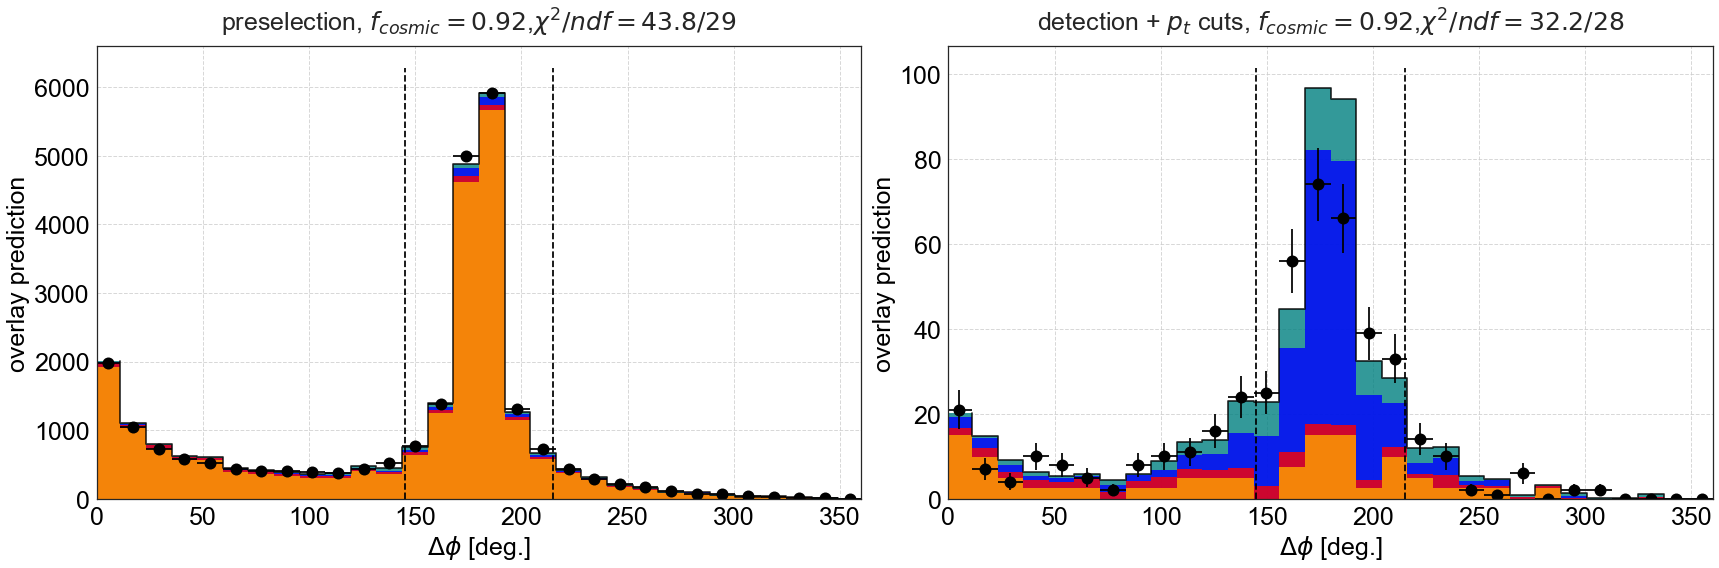

In [80]:
plot_nocut_finalcut(var='delta_phi',x_label=  r'$\Delta \phi$ [deg.]',bins=linspace(-1,361,31),x_varcut=(145,215)
                    ,last_cut_name='soft Pt',last_cut_label='detection + $p_t$ cuts'
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,360),chi2_xrange=(0,360)
                   )

## number of PE in closest flash

In [104]:
cuts_order  = ['no cut','PIDa','length','non-collinearity','vertex activity','delta phi','soft Pt']
cuts_labels = ['preselection','PIDa cut',r'$l_\mu > l_p$ cut','collinearity','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut']
reducedOverlay,pureffOverlay,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to data'

grabbing reduced samples after ( no cut ) and applying cut on ( PIDa )
len(samples_previous_cut): 4
sam(1mu-1p): 5060
sam(other pairs): 4071
sam(cosmic): 9005
sam(CC 1p 0pi): 2389
grabbing reduced samples after ( PIDa ) and applying cut on ( length )
len(samples_previous_cut): 4
sam(1mu-1p): 4284
sam(other pairs): 2268
sam(cosmic): 1300
sam(CC 1p 0pi): 2006
grabbing reduced samples after ( length ) and applying cut on ( non-collinearity )
len(samples_previous_cut): 4
sam(1mu-1p): 3554
sam(other pairs): 1243
sam(cosmic): 688
sam(CC 1p 0pi): 1774
grabbing reduced samples after ( non-collinearity ) and applying cut on ( vertex activity )
len(samples_previous_cut): 4
sam(1mu-1p): 3153
sam(other pairs): 844
sam(cosmic): 386
sam(CC 1p 0pi): 1639
grabbing reduced samples after ( vertex activity ) and applying cut on ( delta phi )
len(samples_previous_cut): 4
sam(1mu-1p): 2140
sam(other pairs): 490
sam(cosmic): 179
sam(CC 1p 0pi): 1409
grabbing reduced samples after ( delta phi ) and applying 

In [109]:
MCbnbDATAcosmicSamples_noFlash = dict()
for pair_type in pair_types:
    MCbnbDATAcosmicSamples_noFlash[pair_type] = MCbnbDATAcosmicSamples[pair_type][MCbnbDATAcosmicSamples[pair_type]['ClosestFlash_TotalPE']<0]
    
reducedOverlay_noFlash,pureffOverlay_noFlash,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples_noFlash
                                                       ,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to overlay for no-flash'

OnBeamFV_noFlash = OnBeamFV[OnBeamFV['ClosestFlash_TotalPE']<0]
OffBeamFV_noFlash = OffBeamFV[OffBeamFV['ClosestFlash_TotalPE']<0]
reducedOnBeam_noFlash,reducedOffBeam_noFlash,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV_noFlash
                                                    ,OffBeamFV=OffBeamFV_noFlash
                                                    ,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to data for no-flash'


MCbnbDATAcosmicSamples_withFlash = dict()
for pair_type in pair_types:
    MCbnbDATAcosmicSamples_withFlash[pair_type] = MCbnbDATAcosmicSamples[pair_type][MCbnbDATAcosmicSamples[pair_type]['ClosestFlash_TotalPE']>=0]
    
reducedOverlay_withFlash,pureffOverlay_withFlash,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples_withFlash
                                                       ,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to overlay for with-flashes'

OnBeamFV_withFlash = OnBeamFV[OnBeamFV['ClosestFlash_TotalPE']>=0]
OffBeamFV_withFlash = OffBeamFV[OffBeamFV['ClosestFlash_TotalPE']>=0]
reducedOnBeam_withFlash,reducedOffBeam_withFlash,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV_withFlash
                                                    ,OffBeamFV=OffBeamFV_withFlash
                                                    ,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to data for with-flashes'

grabbing reduced samples after ( no cut ) and applying cut on ( PIDa )
len(samples_previous_cut): 4
sam(1mu-1p): 18
sam(other pairs): 20
sam(cosmic): 2774
sam(CC 1p 0pi): 8
grabbing reduced samples after ( PIDa ) and applying cut on ( length )
len(samples_previous_cut): 4
sam(1mu-1p): 16
sam(other pairs): 10
sam(cosmic): 338
sam(CC 1p 0pi): 6
grabbing reduced samples after ( length ) and applying cut on ( non-collinearity )
len(samples_previous_cut): 4
sam(1mu-1p): 13
sam(other pairs): 5
sam(cosmic): 181
sam(CC 1p 0pi): 6
grabbing reduced samples after ( non-collinearity ) and applying cut on ( vertex activity )
len(samples_previous_cut): 4
sam(1mu-1p): 9
sam(other pairs): 3
sam(cosmic): 99
sam(CC 1p 0pi): 4
grabbing reduced samples after ( vertex activity ) and applying cut on ( delta phi )
len(samples_previous_cut): 4
sam(1mu-1p): 6
sam(other pairs): 1
sam(cosmic): 44
sam(CC 1p 0pi): 4
grabbing reduced samples after ( delta phi ) and applying cut on ( soft Pt )
len(samples_previous_c

preselection:
np.sum(h_OnBeam): 20935
np.sum(h_stack): 15993.1944774
preselection:
np.sum(h_OnBeam): 2844
np.sum(h_stack): 6907.64854434


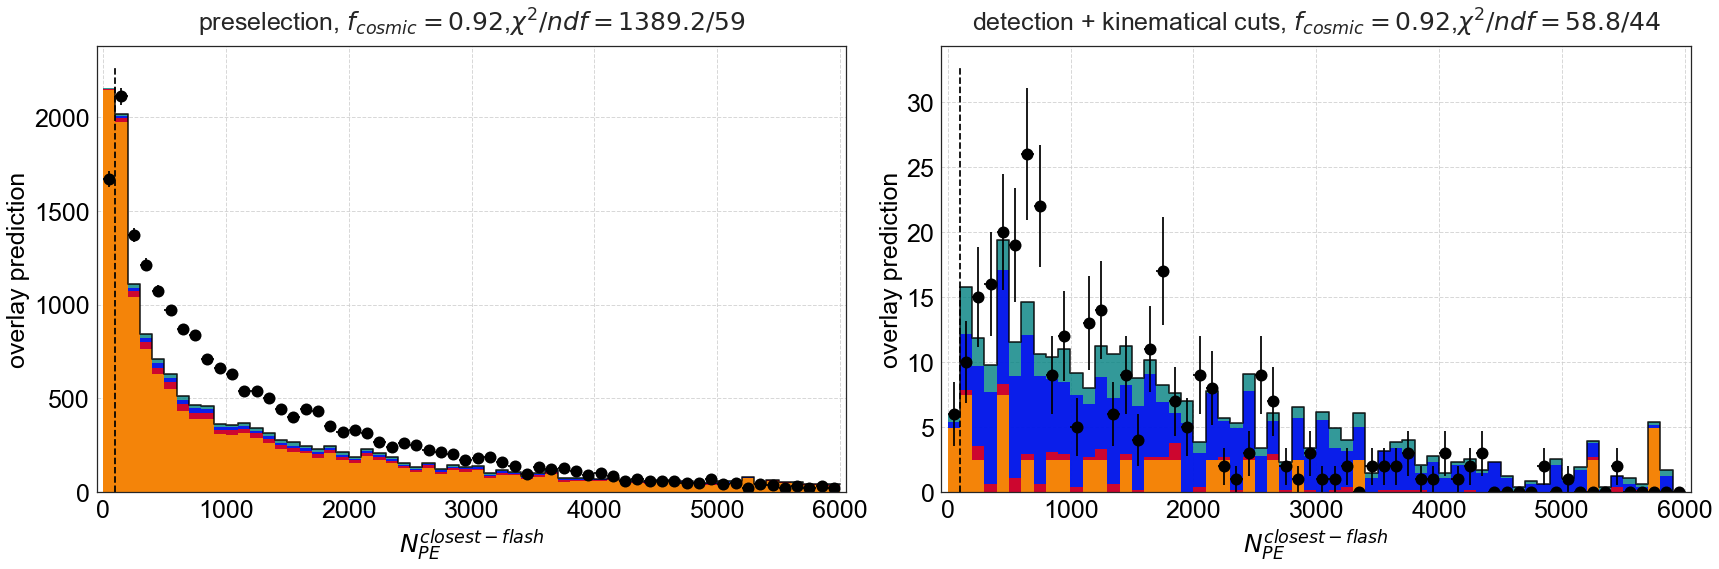

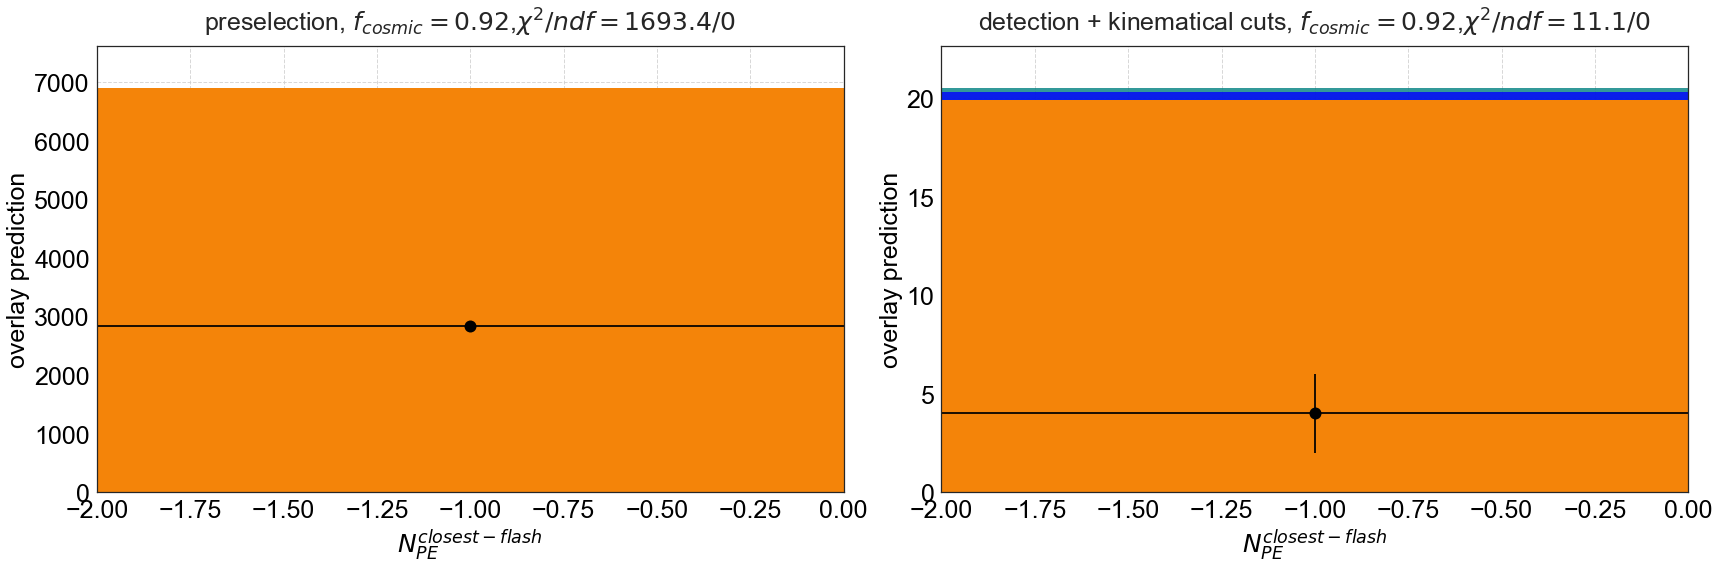

In [117]:
plot_nocut_finalcut(var='ClosestFlash_TotalPE',x_label=  r'$N_{PE}^{closest-flash}$',bins=linspace(-1,6000,61)
                    ,x_varcut=(100,np.inf)
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam_withFlash
                    ,reducedOnBeam=reducedOnBeam_withFlash
                    ,reducedOverlay=reducedOverlay_withFlash
                    ,f_Cosmic=f_Cosmic,x_ticks = [0,500,1000,1500]
#                     ,xlim=(0,4500)
                    ,chi2_xrange=(0,4500)
                    ,debug=2
                   )

plot_nocut_finalcut(var='ClosestFlash_TotalPE',x_label=  r'$N_{PE}^{closest-flash}$',bins=linspace(-2,0,2)
                    ,x_varcut=(100,np.inf)
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam_noFlash
                    ,reducedOnBeam=reducedOnBeam_noFlash
                    ,reducedOverlay=reducedOverlay_noFlash
                    ,f_Cosmic=f_Cosmic,x_ticks = [0,500,1000,1500]
                    ,chi2_xrange=(-2,0),xlim=(-2,0)
                    ,debug=2
                   )

## $p_t$

In [87]:
cuts_order  = ['no cut','PIDa','flash','length','non-collinearity','vertex activity','delta phi']
cuts_labels = ['preselection','PIDa cut','PMT cuts',r'$l_\mu > l_p$ cut','collinearity','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut']
reducedOverlay,pureffOverlay,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to data'

grabbing reduced samples after ( no cut ) and applying cut on ( PIDa )
len(samples_previous_cut): 4
sam(1mu-1p): 5060
sam(other pairs): 4071
sam(cosmic): 9005
sam(CC 1p 0pi): 2389
grabbing reduced samples after ( PIDa ) and applying cut on ( flash )
len(samples_previous_cut): 4
sam(1mu-1p): 4284
sam(other pairs): 2268
sam(cosmic): 1300
sam(CC 1p 0pi): 2006
grabbing reduced samples after ( flash ) and applying cut on ( length )
len(samples_previous_cut): 4
sam(1mu-1p): 4033
sam(other pairs): 2190
sam(cosmic): 638
sam(CC 1p 0pi): 1876
grabbing reduced samples after ( length ) and applying cut on ( non-collinearity )
len(samples_previous_cut): 4
sam(1mu-1p): 3336
sam(other pairs): 1205
sam(cosmic): 342
sam(CC 1p 0pi): 1656
grabbing reduced samples after ( non-collinearity ) and applying cut on ( vertex activity )
len(samples_previous_cut): 4
sam(1mu-1p): 2969
sam(other pairs): 819
sam(cosmic): 189
sam(CC 1p 0pi): 1533
grabbing reduced samples after ( vertex activity ) and applying cut on 

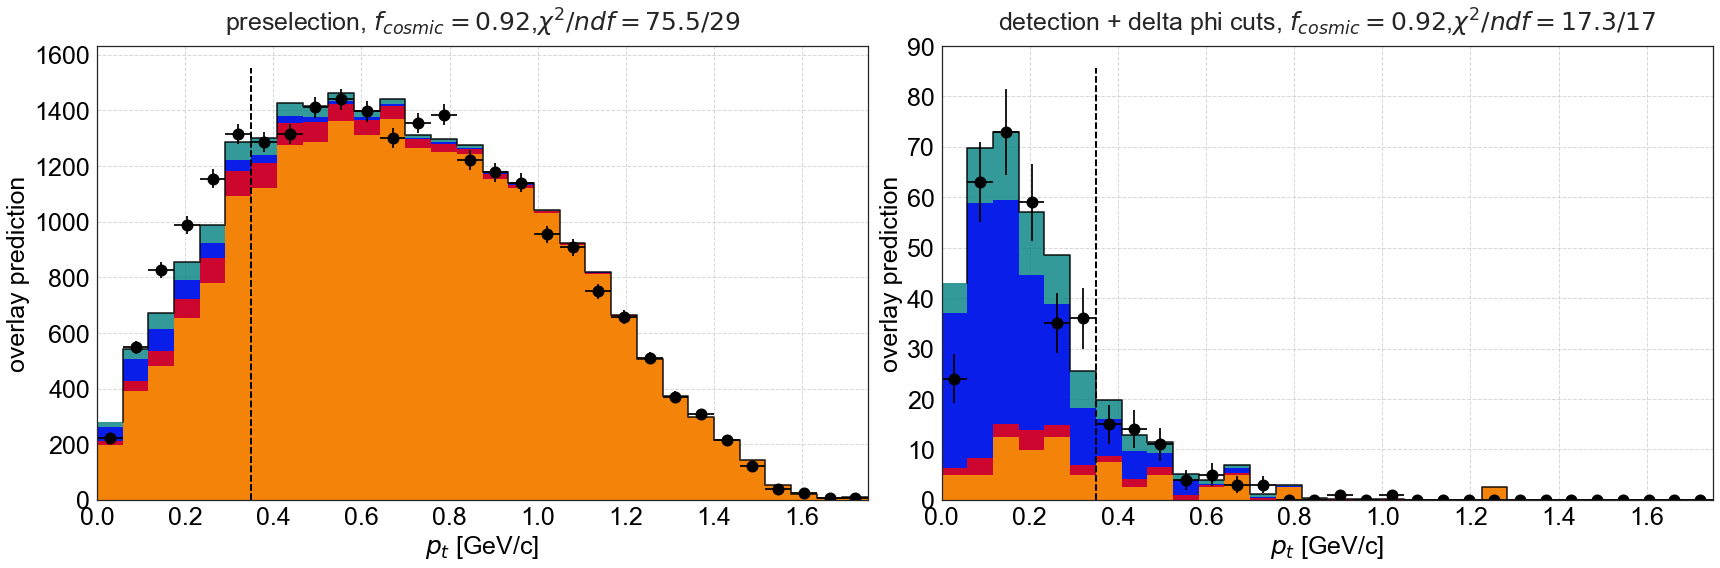

In [88]:
plot_nocut_finalcut(var='reco_Pt',x_label=  r'$p_{t}$ [GeV/c]',bins=linspace(0,1.75,31),x_varcut=(0.35,0.35)
                    ,last_cut_name='delta phi',last_cut_label='detection + delta phi cuts'
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,1.75),chi2_xrange=(0,1)
                   )

## PIDa

In [14]:
do_PIDaCali = True
cuts_order  = ['no cut','flash','length','non-collinearity','vertex activity','delta phi','soft Pt']
cuts_labels = ['preselection','PMT cuts',r'$l_\mu > l_p$ cut','collinearity','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut']
reducedOverlay,pureffOverlay,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to data'

KeyError: '1mu-1p'

In [15]:
plot_nocut_finalcut(var='PIDa_assigned_proton',x_label= r'$PID_{a}^{p}$',bins=linspace(0,30,51)
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,30),chi2_xrange=(5,30)
                   )

NameError: name 'reducedOffBeam' is not defined

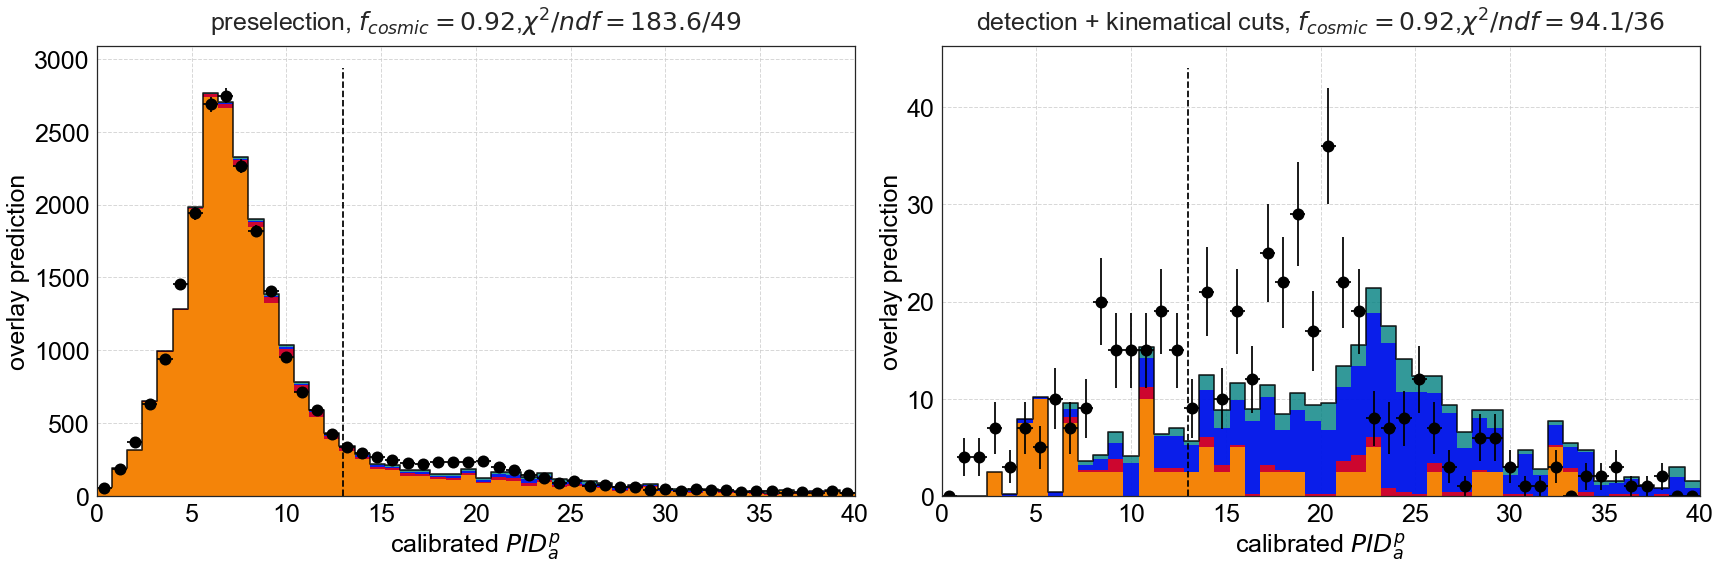

In [18]:
plot_nocut_finalcut(var='PIDaCali_assigned_proton',x_label= r'calibrated $PID_{a}^{p}$',bins=linspace(0,40,51)
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,40),chi2_xrange=(10,40)
                   )

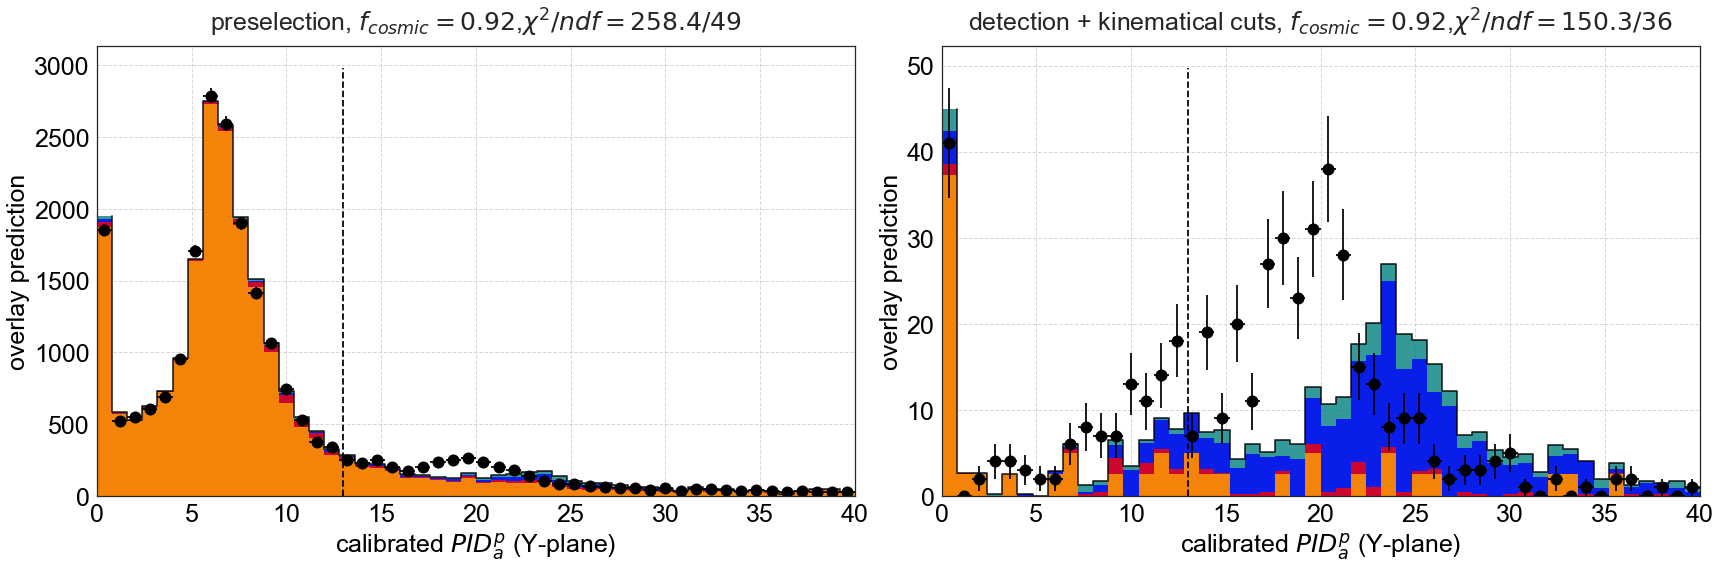

In [20]:
plot_nocut_finalcut(var='PIDaCaliYplane_assigned_proton',x_label= r'calibrated $PID_{a}^{p}$ (Y-plane)',bins=linspace(0,40,51)
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,40),chi2_xrange=(10,40)
                   )

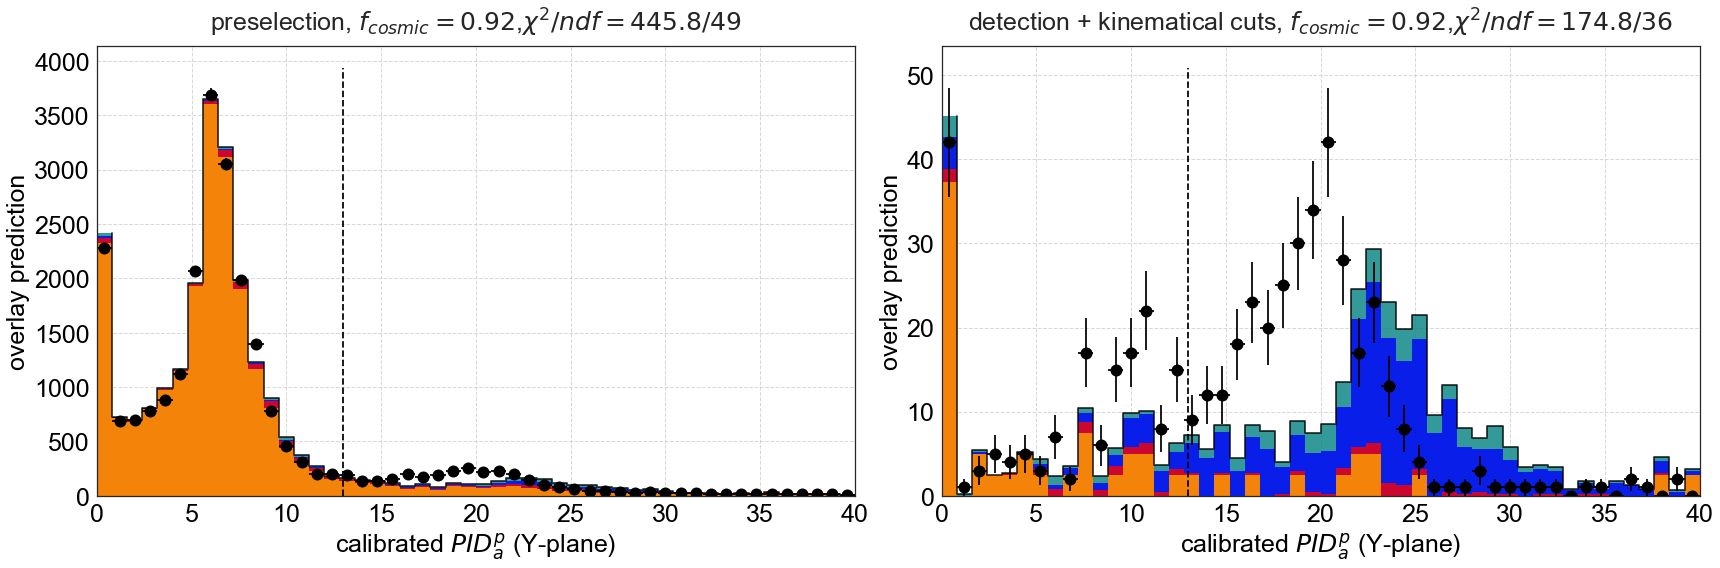

In [19]:
plot_nocut_finalcut(var='pandoraNucalipidCaliYplane_assigned_proton',x_label= r'calibrated $PID_{a}^{p}$ (Y-plane)',bins=linspace(0,40,51)
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,40),chi2_xrange=(10,40)
                   )

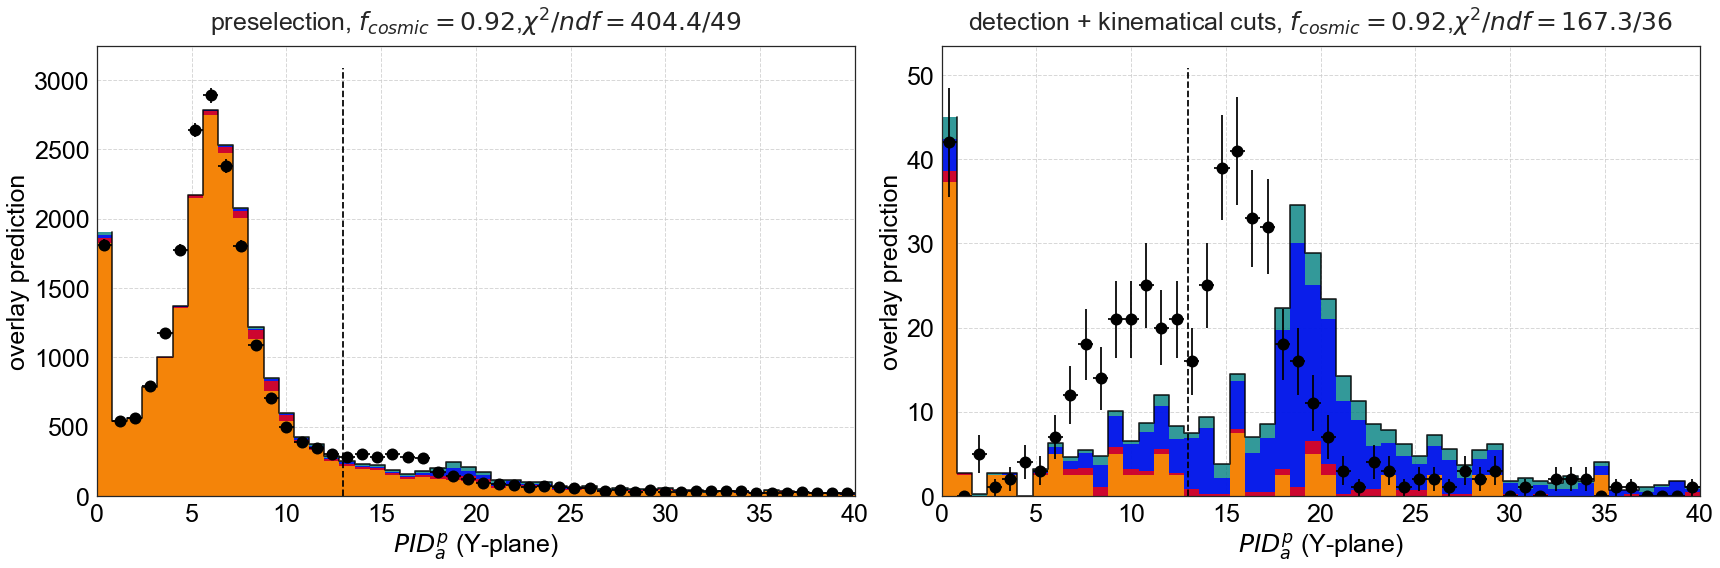

In [21]:
plot_nocut_finalcut(var='pandoraNupidCaliYplane_assigned_proton',x_label= r'$PID_{a}^{p}$ (Y-plane)',bins=linspace(0,40,51)
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,40),chi2_xrange=(10,40)
                   )

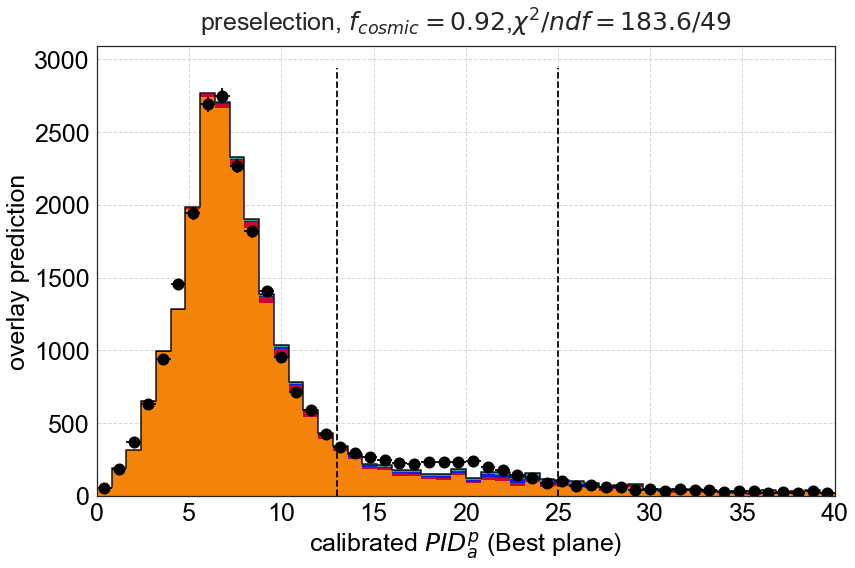

In [41]:
plot_nocut_finalcut(var='PIDaCali_assigned_proton',x_label= r'calibrated $PID_{a}^{p}$ (Best plane)'
                    ,bins=linspace(0,40,51),x_varcut=(13,25),figsize=(12,8)
                    ,do_only_preselection=True
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,40),chi2_xrange=(10,40)
                   )
plt.tight_layout()
plt.savefig('/Users/erezcohen/Desktop/PIDaCali_OnBeam_vs_Overlay.pdf')

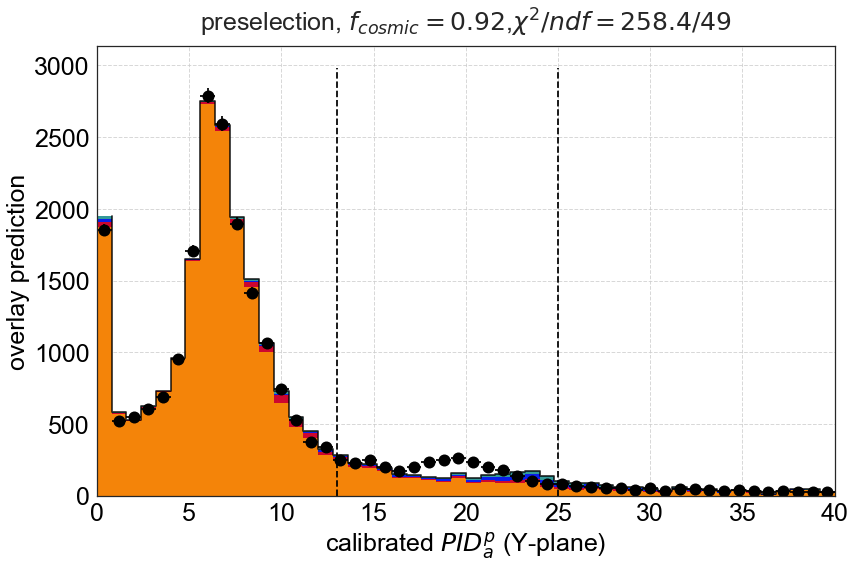

In [42]:
var='PIDaCaliYplane_assigned_proton'
plot_nocut_finalcut(var=var,x_label= r'calibrated $PID_{a}^{p}$ (Y-plane)'
                    ,bins=linspace(0,40,51),x_varcut=(13,25),figsize=(12,8)
                    ,do_only_preselection=True
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,40),chi2_xrange=(10,40)
                   )
plt.tight_layout()
plt.savefig('/Users/erezcohen/Desktop/'+var+'_OnBeam_vs_Overlay.pdf')

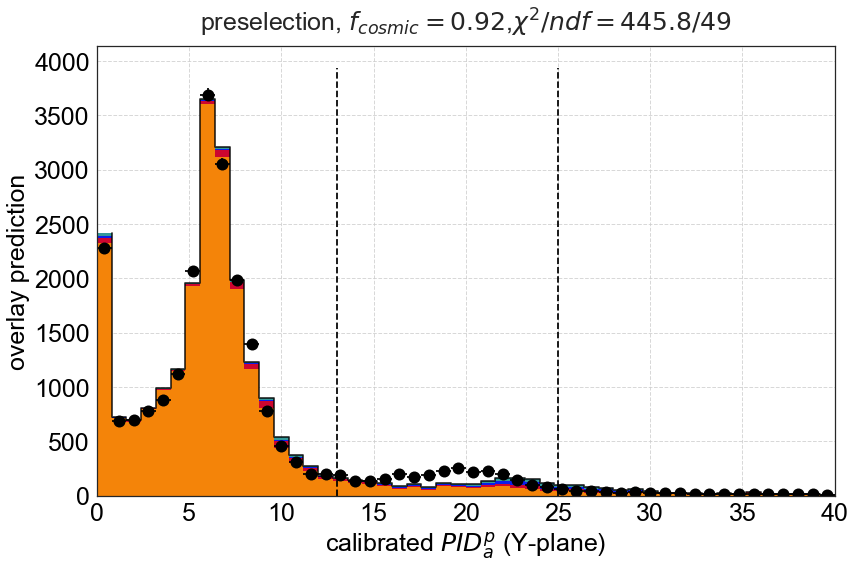

In [43]:
var='pandoraNucalipidCaliYplane_assigned_proton'
plot_nocut_finalcut(var=var,x_label= r'calibrated $PID_{a}^{p}$ (Y-plane)'
                    ,bins=linspace(0,40,51),x_varcut=(13,25),figsize=(12,8)
                    ,do_only_preselection=True
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,40),chi2_xrange=(10,40)
                   )
plt.tight_layout()
plt.savefig('/Users/erezcohen/Desktop/'+var+'_OnBeam_vs_Overlay.pdf')

## vertex activity

In [118]:
cuts_order  = ['no cut','PIDa','flash','length','non-collinearity','delta phi','soft Pt']
cuts_labels = ['preselection','PIDa cut','PMT cuts',r'$l_\mu > l_p$ cut','collinearity', r'$\Delta \phi$ cut',r'$p_t$ cut']
reducedOverlay,pureffOverlay,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order,do_PIDaCali=do_PIDaCali)
print 'done applying cuts to data'

grabbing reduced samples after ( no cut ) and applying cut on ( PIDa )
len(samples_previous_cut): 4
sam(1mu-1p): 5060
sam(other pairs): 4071
sam(cosmic): 9005
sam(CC 1p 0pi): 2389
grabbing reduced samples after ( PIDa ) and applying cut on ( flash )
len(samples_previous_cut): 4
sam(1mu-1p): 4284
sam(other pairs): 2268
sam(cosmic): 1300
sam(CC 1p 0pi): 2006
grabbing reduced samples after ( flash ) and applying cut on ( length )
len(samples_previous_cut): 4
sam(1mu-1p): 4033
sam(other pairs): 2190
sam(cosmic): 638
sam(CC 1p 0pi): 1876
grabbing reduced samples after ( length ) and applying cut on ( non-collinearity )
len(samples_previous_cut): 4
sam(1mu-1p): 3336
sam(other pairs): 1205
sam(cosmic): 342
sam(CC 1p 0pi): 1656
grabbing reduced samples after ( non-collinearity ) and applying cut on ( delta phi )
len(samples_previous_cut): 4
sam(1mu-1p): 2969
sam(other pairs): 819
sam(cosmic): 189
sam(CC 1p 0pi): 1533
grabbing reduced samples after ( delta phi ) and applying cut on ( soft Pt )


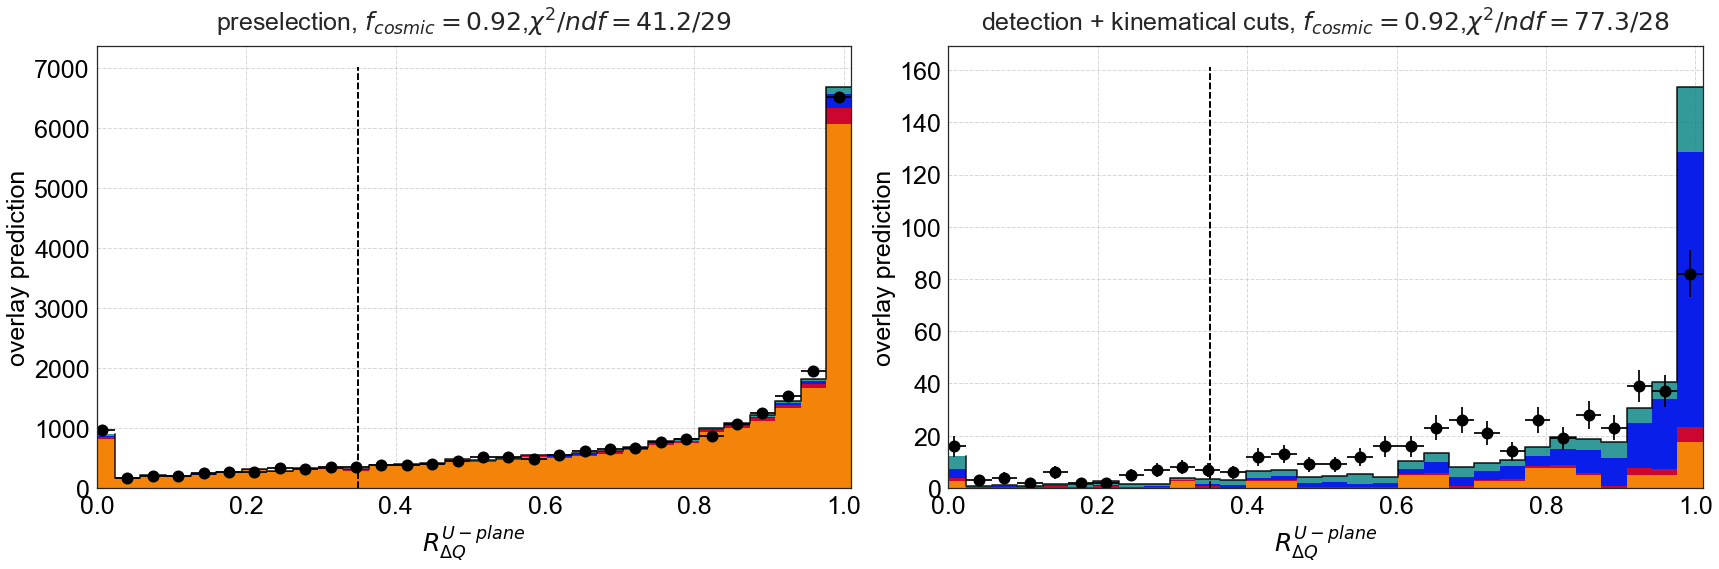

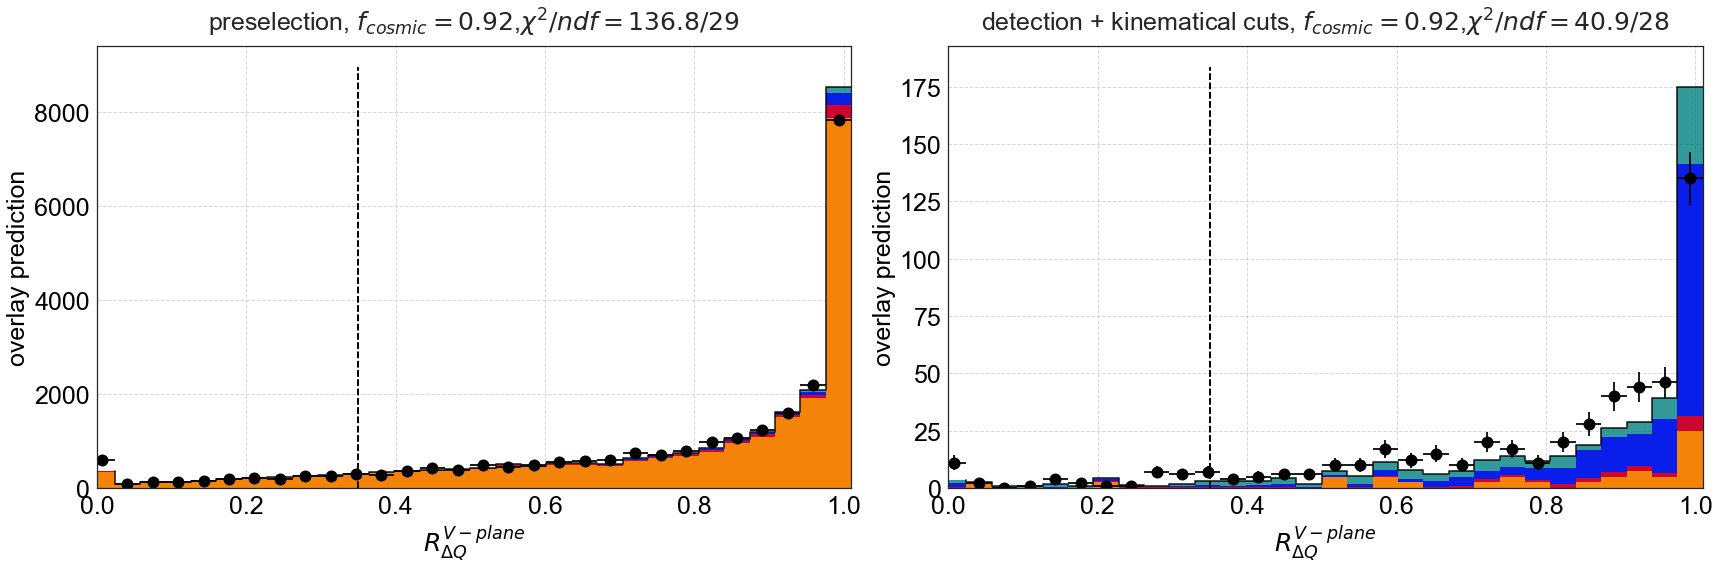

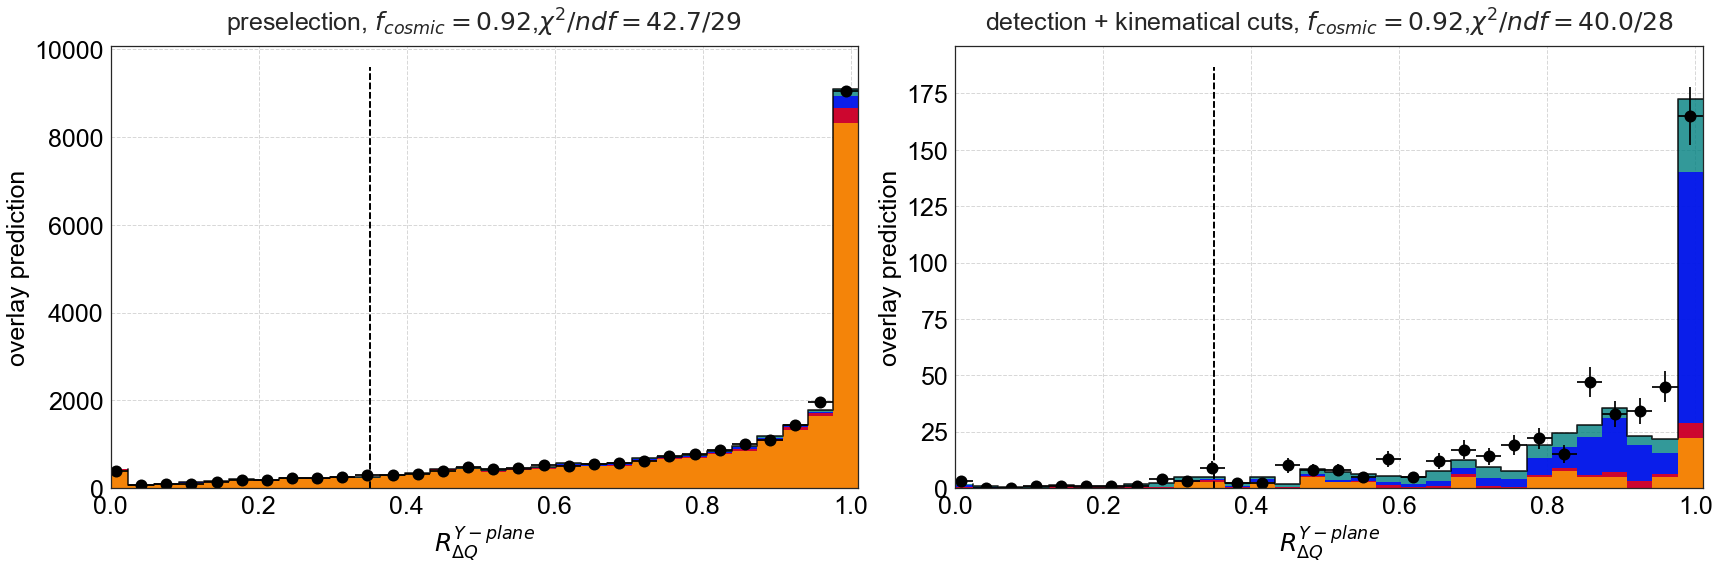

In [122]:
plot_nocut_finalcut(var='RdQaroundVertex[plane 0][50 wires x 100 ticks]',x_label=  r'$R_{\Delta Q}^{U-plane}$'
                    ,bins=linspace(-0.01,1.01,31),x_varcut=(0.35,0.35)
                    ,last_cut_name='soft Pt',last_cut_label='detection + kinematical cuts'
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,1.01),chi2_xrange=(0,1)
                   )

plot_nocut_finalcut(var='RdQaroundVertex[plane 1][50 wires x 100 ticks]',x_label=  r'$R_{\Delta Q}^{V-plane}$'
                    ,bins=linspace(-0.01,1.01,31),x_varcut=(0.35,0.35)
                    ,last_cut_name='soft Pt',last_cut_label='detection + kinematical cuts'
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,1.01),chi2_xrange=(0,1)
                   )

plot_nocut_finalcut(var='RdQaroundVertex[plane 2][50 wires x 100 ticks]',x_label=  r'$R_{\Delta Q}^{Y-plane}$'
                    ,bins=linspace(-0.01,1.01,31),x_varcut=(0.35,0.35)
                    ,last_cut_name='soft Pt',last_cut_label='detection + kinematical cuts'
                    ,overlay_scalings=overlay_scalings
                    ,scaling_name='N(On) scaling and f(cosmic)=0.92'                    
                    ,reducedOffBeam=reducedOffBeam,reducedOnBeam=reducedOnBeam,reducedOverlay=reducedOverlay
                    ,f_Cosmic=f_Cosmic
                    ,xlim=(0,1.01),chi2_xrange=(0,1)
                   )